In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [4]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'mvpa2')

In [5]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [6]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)

    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [7]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

### Training

In [8]:
from utils.distrib import color_smart_diff, color_smart_diff_outer
from scipy.spatial.distance import cdist

def deg_signed_diff(d1, epoch=180):
    d2 = - np.sign(d1) * (epoch - np.abs(d1))
    mask = np.abs(d1) < np.abs(d2)
    d = mask * d1 + (~mask) * d2
    # finally, convert 90 to -90
    half_epoch = epoch // 2
    mask_90 = d == half_epoch
    d = mask_90 * (-half_epoch) + (~mask_90) * d
    return d


class DistFunctions:
    """ define all distance function """
    @classmethod
    def diff(cls, x1, x2, dist_name, pairwise):
        if dist_name == 'cos':
            return cls.cos_diff(x1, x2, pairwise)
        elif dist_name == 'rad':
            return cls.rad_diff(x1, x2, pairwise)
        elif dist_name == 'deg':
            return cls.deg_diff(x1, x2, pairwise)
        elif dist_name == 'euc':
            return cls.euclidean_diff(x1, x2, pairwise)
        else:
            raise NotImplementedError(f'Unknown distance {dist_name}')

    @classmethod
    def cos_diff(cls, x1, x2, pairwise):
        x1 = x1 / np.linalg.norm(x1, axis=-1, keepdims=True)
        x2 = x2 / np.linalg.norm(x2, axis=-1, keepdims=True)
        if pairwise:
            dists = cdist(x1, x2, metric='cosine')
        else:
            similarity = np.sum(x1 * x2, axis=-1)
            dists = 1 - similarity
        return dists
    
    @classmethod
    def euclidean_diff(cls, x1, x2, pairwise):
        if pairwise:
            dists = cdist(x1, x2, metric='euclidean')
        else:
            diffs = x1 - x2
            dists = np.linalg.norm(diffs, axis=-1)
        return dists
    
    @classmethod
    def deg_diff(cls, x1, x2, pairwise):
        if pairwise:
            assert len(x2.shape) == 1
            x1 = x1[..., np.newaxis]
            d1 = x1 - x2 # expand last dim
        else:
            d1 = x1 - x2 # elementwise

        # convert dists to degree dists
        deg_diffs = np.abs(deg_signed_diff(d1))
        return deg_diffs
    
    @classmethod
    def rad_diff(cls, x1, x2, pairwise):
        dists = np.abs(cls.deg_diff(x1, x2, pairwise))      
        dists = np.deg2rad(dists)
        return dists

In [9]:
from scipy.ndimage import zoom

class FeatureDowngrade:
    def __init__(self, params):
        self.params = params

    def get_converted_features(self, Xs):
        new_features = []
        # 0d
        if '0d' in self.params:
            d0_features = self.get_0d(Xs)
            new_features.append(d0_features)
        #1d
        if '1d' in self.params:
            d1_features = self.shrink_1d(Xs)
            new_features.append(d1_features)
        #2d
        if '2d' in self.params:
            d2_features = self.shrink_2d(Xs)
            new_features.append(d2_features)
        new_features = np.concatenate(new_features, axis=-1)
        return new_features

    def get_0d(self, Xs):
        d0_params = self.params['0d']
        d0_features = Xs[..., d0_params['old']]
        return d0_features

    def shrink_1d(self, Xs):
        d1_params = self.params['1d']
        d1_old = Xs[..., d1_params['old']]
        d1_new = d1_old.copy()
        d1_shrink_ratio = d1_params.get('zoom_ratio', None)
        if d1_shrink_ratio is None:
            return d1_new
        else:
            d1_shrink_ratio_list = np.ones(len(d1_new.shape))
            d1_shrink_ratio_list[-1] = d1_shrink_ratio
            d1_new = zoom(d1_new, 
                zoom=d1_shrink_ratio_list, mode='wrap', order=1)
            return d1_new

    def shrink_2d(self, Xs):
        d2_params = self.params['2d']
        d2_old = Xs[..., d2_params['old']]
        d2_new = d2_old.copy()
        d2_shrink_ratio = d2_params.get('zoom_ratio', None)
        if d2_shrink_ratio is None:
            return d2_new
        else:
            # reformat d2
            H, W = d2_params['H'], d2_params['W']
            original_shape = d2_new.shape
            new_shape = (*original_shape[:-1], H, W)
            d2_new = d2_new.reshape(new_shape)

            # zoom
            d2_shrink_ratio_list = np.ones(len(d2_new.shape))
            d2_shrink_ratio_list[-2:] = d2_shrink_ratio
            d2_new = zoom(d2_new, zoom=d2_shrink_ratio_list, mode='wrap', order=1)

            # flatten
            new_shape = (*original_shape[:-1], d2_new.shape[-2] * d2_new.shape[-1])
            d2_new = d2_new.reshape(new_shape)

            return d2_new

class ForwardModel:
    def __init__(self, feature_conversion_params, n_channels):
        self.feature_conversion = FeatureDowngrade(feature_conversion_params)
        # create channels and channel centers
        self.n_channels = n_channels
        self.channel_bins = np.linspace(0, 180, n_channels+1)
        self.channel_cenetrs = (self.channel_bins[1:] + self.channel_bins[:-1]) / 2

    def raw_ys_to_channel_weights(self, ys, sharpness):
        # convert first to radian differece
        rad_diffs = DistFunctions.diff(
            ys, self.channel_cenetrs, 
            dist_name='rad', pairwise=True)
        # rad diffs to weights
        weights = np.exp(sharpness * np.cos(rad_diffs))
        # normalize
        weights = weights / np.sum(weights, axis=-1, keepdims=True)
        return weights

    def convert_xinputs(self, Xs):
        Xs = self.feature_conversion.get_converted_features(Xs)
        return Xs

    def get_channel_patterns(self, Xs, ys, item_weights, sharpness):
        # convert xs
        Xs = self.convert_xinputs(Xs)
        # get the channel weights
        ys = self.raw_ys_to_channel_weights(ys, sharpness)
        # get the total weights
        ys = item_weights[..., None] * ys
        ys = np.sum(ys, axis=-2) # across items
        ys = ys / np.sum(ys, axis=-1, keepdims=True) # normalize
        # least square
        C_hat = np.linalg.pinv(ys.T @ ys) @ ys.T @ Xs
        return Xs, ys, C_hat
        
    def find_best_y_transform(self, Xs, ys, item_weights, sharpness_range, x_dist_func, x_thresh):
        # find the best y transform
        best_sharpness = None
        best_loss = np.inf
        for sharpness in sharpness_range:
            Xs_test, ys_test, C_hat_test = self.get_channel_patterns(
                Xs, ys, item_weights, sharpness)
            Xs_pred = ys_test @ C_hat_test
            # first check if the range is ok
            x_outlier_ratio = np.mean((Xs_pred > x_thresh) | (Xs_pred < -x_thresh))
            loss = DistFunctions.diff(
                Xs_pred, Xs_test, x_dist_func, pairwise=False)
            loss = np.mean(loss)
            print(f'sharpness {sharpness:.2f} loss {loss:.6f} (invalid: {x_outlier_ratio:.2f})')
            if loss < best_loss:
                best_loss = loss
                best_sharpness = sharpness

        return best_sharpness, best_loss
    
    def predict(self, Xs, C_hat):
        Xs = self.convert_xinputs(Xs)
        ys = Xs @ C_hat.T @ np.linalg.pinv(C_hat @ C_hat.T)
        return Xs, ys

### Get Xs and Ys

### Find best sharpness value

In [10]:
d2_H, d2_W = 15, 15

DEFAULT_FEATURE_CONVERSION = {
    '0d': {
        'old': np.array([0, 1]),
    },
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.4,
    }    
}

In [11]:
sharpness_range = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 30, 40]

In [12]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)
delay_phases = np.split(delay_phase, 9) # 9 x 10 time points

#### ISI phase best sharpness

In [13]:
def reformat_all_loaded(phase, stim_names, cond_lmb):
    all_xs, all_ys, all_dfs, all_tags = [], [], [], []
    for subj in all_subjs:
        features, behavior_df = load_subject_time_feature(subj, phase)
        mask = cond_lmb(behavior_df)
        features = features[mask]
        behavior_df = behavior_df[mask]
        behavior_ys = behavior_df[stim_names].values
        all_xs.append(features)
        all_ys.append(behavior_ys)
        all_dfs.append(behavior_df)
        all_tags.append([subj] * len(features))
    # compute the default weights
    all_xs = np.concatenate(all_xs, axis=0)
    all_ys = np.concatenate(all_ys, axis=0)
    all_tags = np.concatenate(all_tags, axis=0)
    all_dfs = pd.concat(all_dfs, axis=0, ignore_index=True)
    return all_xs, all_ys, all_dfs, all_tags

In [14]:
valid_1st_lmb = lambda df: ((df['stim_1_to_report']) | (df['trial_code'] == 1)).to_numpy()
ISI_xs, ISI_ys, _, _ = reformat_all_loaded(ISI_phase, ['stim_1'], valid_1st_lmb)

In [15]:
ISI_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=18)
ISI_best_sharpness, ISI_best_loss = ISI_forward_model.find_best_y_transform(
    ISI_xs, ISI_ys, item_weights=np.ones_like(ISI_ys), 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)

sharpness 0.50 loss 7.350904 (invalid: 0.00)
sharpness 1.00 loss 7.350913 (invalid: 0.00)
sharpness 2.00 loss 7.350817 (invalid: 0.00)
sharpness 4.00 loss 7.350714 (invalid: 0.00)
sharpness 6.00 loss 7.350879 (invalid: 0.00)
sharpness 8.00 loss 7.350660 (invalid: 0.00)
sharpness 10.00 loss 7.350468 (invalid: 0.00)
sharpness 12.00 loss 7.350642 (invalid: 0.00)
sharpness 14.00 loss 7.350641 (invalid: 0.00)
sharpness 16.00 loss 7.350644 (invalid: 0.00)
sharpness 20.00 loss 7.350651 (invalid: 0.00)
sharpness 30.00 loss 7.350675 (invalid: 0.00)
sharpness 40.00 loss 7.350693 (invalid: 0.00)


In [16]:
ISI_best_sharpness

10

#### Delay phase best sharpness

In [17]:
valid_both_lmb = lambda df: (
    (df['stim_1_to_report'] & df['stim_2_to_report']) | 
    (df['trial_code'] == 1)).to_numpy()

delay_xs, delay_ys, _, _ = reformat_all_loaded(
    delay_phase, ['stim_1', 'stim_2'], valid_both_lmb)

In [18]:
delay_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=18)
item_weights = np.ones_like(delay_ys) * 0.5 # two items
delay_best_sharpness, delay_best_loss = delay_forward_model.find_best_y_transform(
    delay_xs, delay_ys, item_weights=item_weights, 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)

sharpness 0.50 loss 7.190600 (invalid: 0.00)
sharpness 1.00 loss 7.190586 (invalid: 0.00)
sharpness 2.00 loss 7.190839 (invalid: 0.00)
sharpness 4.00 loss 7.190722 (invalid: 0.00)
sharpness 6.00 loss 7.190328 (invalid: 0.00)
sharpness 8.00 loss 7.190577 (invalid: 0.00)
sharpness 10.00 loss 7.190869 (invalid: 0.00)
sharpness 12.00 loss 7.190795 (invalid: 0.00)
sharpness 14.00 loss 7.190783 (invalid: 0.00)
sharpness 16.00 loss 7.190780 (invalid: 0.00)
sharpness 20.00 loss 7.190773 (invalid: 0.00)
sharpness 30.00 loss 7.190746 (invalid: 0.00)
sharpness 40.00 loss 7.190715 (invalid: 0.00)


In [19]:
delay_best_sharpness

6

### Convert training data into patterns

In [20]:
DEFAULT_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION,
        'n_channels': 18,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [21]:
from tqdm import tqdm

def across_subj_cross_phase_iterator(
        phase1, phase2, 
        phase1_stim_types, phase2_stim_types,
        phase1_lmb, phase2_lmb, item_weights_lmb,
        kfold):
    
    # load all data for all subjects
    xs1, ys1, df1, tags1 = reformat_all_loaded(
        phase1, phase1_stim_types, phase1_lmb)
    xs2, ys2, df2, tags2 = reformat_all_loaded(
        phase2, phase2_stim_types, phase2_lmb)

    # cv
    all_subj_ids = list(set(tags1))
    np.random.shuffle(all_subj_ids)
    heldout_subj_ids = np.array_split(all_subj_ids, kfold)
    heldout_subj_ids = [set(subj_ids) for subj_ids in heldout_subj_ids]

    for i in tqdm(list(range(kfold))):
        # train and test mask
        train_heldout_mask = np.array(
            [s in heldout_subj_ids[i] for s in tags1])
        train_mask = ~train_heldout_mask
        train_subj_ids = set(tags1[train_mask])
        test_heldout_mask = np.array(
            [s in train_subj_ids for s in tags2])
        test_mask = ~test_heldout_mask
        # fetch data
        fold_train_xs, fold_train_ys = xs1[train_mask], ys1[train_mask]
        fold_test_xs, fold_test_ys = xs2[test_mask], ys2[test_mask]
        fold_train_df, fold_test_df = df1[train_mask], df2[test_mask]
        # yield data
        yield {
            'xs1': fold_train_xs,
            'ys1': fold_train_ys,
            'df1': fold_train_df,
            'xs2': fold_test_xs,
            'ys2': fold_test_ys,
            'df2': fold_test_df,
            'item_weights': item_weights_lmb(fold_train_df),
        }

In [22]:
def train_test_invert_encoding(
        model_params, xs1, xs2, ys1, ys2, df1, df2,
        item_weights=None):
    # get the weight of items
    if item_weights is None:
        item_weights = ~(np.isnan(ys1))
        item_weights = item_weights / np.sum(
            item_weights, axis=-1, keepdims=True)
        
    model = ForwardModel(**model_params['init'])
    sharpness = model_params['forward']['sharpness']
    # get pattern
    xs1_trans, ys1_trans, patterns = model.get_channel_patterns(
        xs1, ys1, item_weights, sharpness)
    # predict
    xs2_trans, ys_pred = model.predict(xs2, patterns)
    # also get the converted ys2
    ys2_trans = model.raw_ys_to_channel_weights(ys2, sharpness)
    # collect results
    results = {
        'list': {
            # 'train_xs': xs1,
            # 'train_xs_converted': xs1_trans,
            # 'train_ys': ys1,
            # 'train_ys_converted': ys1_trans,
            'test_xs': xs2,
            'test_xs_converted': xs2_trans,
            'test_ys': ys2,
            'test_ys_converted': ys2_trans,
            'preds': ys_pred,
        },
        'df': {
            # 'train_df': df1,
            'test_df': df2,
        },
        'np': {
            'pattern': patterns,
        }
        
    }
    return results

In [23]:
from tqdm import tqdm

def cv_train_test_invert_encoding(
        model_params, phase1, phase2, 
        phase1_stim_types, phase2_stim_types,
        phase1_lmb, phase2_lmb,
        item_weights_lmb, kfold):
    results = []
    progress_bar = tqdm(total=kfold, desc="Processing")
    for data in across_subj_cross_phase_iterator(
            phase1, phase2, phase1_stim_types, phase2_stim_types,
            phase1_lmb, phase2_lmb, item_weights_lmb, kfold):
        result = train_test_invert_encoding(model_params, **data)
        results.append(result)
        progress_bar.update(1)

    collected = {}
    for k in results[0]['list']:
        collected[k] = np.concatenate(
            [r['list'][k] for r in results], axis=0)
    for k in results[0]['df']:
        collected[k] = pd.concat(
            [r['df'][k] for r in results], ignore_index=True)
    for k in results[0]['np']:
        collected[k] = [r['np'][k] for r in results]
        collected[k] = np.mean(collected[k], axis=0)
    return collected

## Check decoding quality over the whole delay

In [24]:
item_weights_lmb = lambda df: np.ones((len(df), 2)) * 0.5
n_subjects = len(all_subjs)
full_delay_phase_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    valid_both_lmb, valid_both_lmb, 
    item_weights_lmb, n_subjects)

Processing:   0%|          | 0/33 [00:00<?, ?it/s]

Processing: 100%|██████████| 33/33 [00:06<00:00,  5.15it/s]


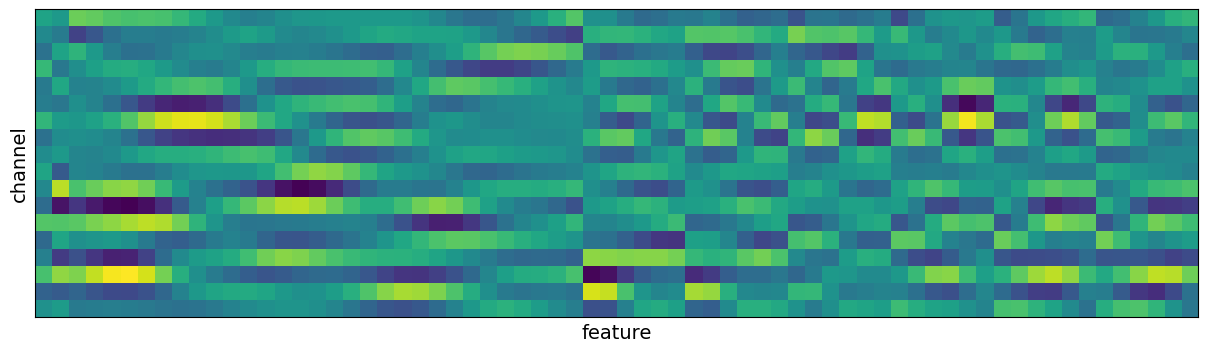

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(25, 4))
ax.imshow(full_delay_phase_results['pattern'])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('feature', fontsize=14)
ax.set_ylabel('channel', fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_channel_pattern.png')
plt.savefig(plot_path)

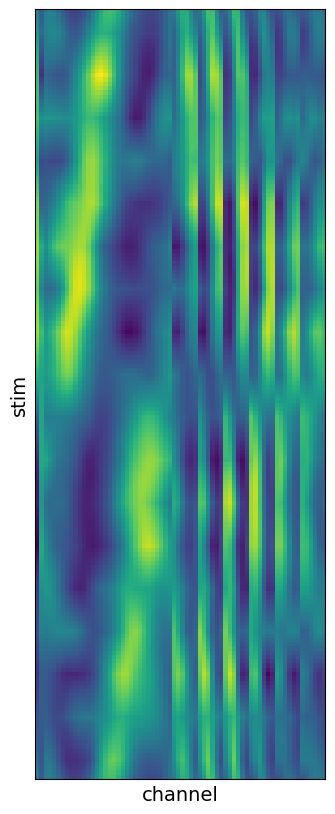

In [26]:
delay_model = ForwardModel(**DEFAULT_FORWARD_MODEL_PARAMS['init'])
delay_sharpness = DEFAULT_FORWARD_MODEL_PARAMS['forward']['sharpness']

channel_weight_projection = delay_model.raw_ys_to_channel_weights(
    np.arange(180), delay_sharpness)
full_patterns = channel_weight_projection @ full_delay_phase_results['pattern'] 

fig, ax = plt.subplots(1, figsize=(15, 10))
ax.imshow(full_patterns)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('stim', fontsize=14)
ax.set_xlabel('channel', fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_pattern.png')
plt.savefig(plot_path)

### center all encoded

#### convert channel weights to (distribution of) stimuli

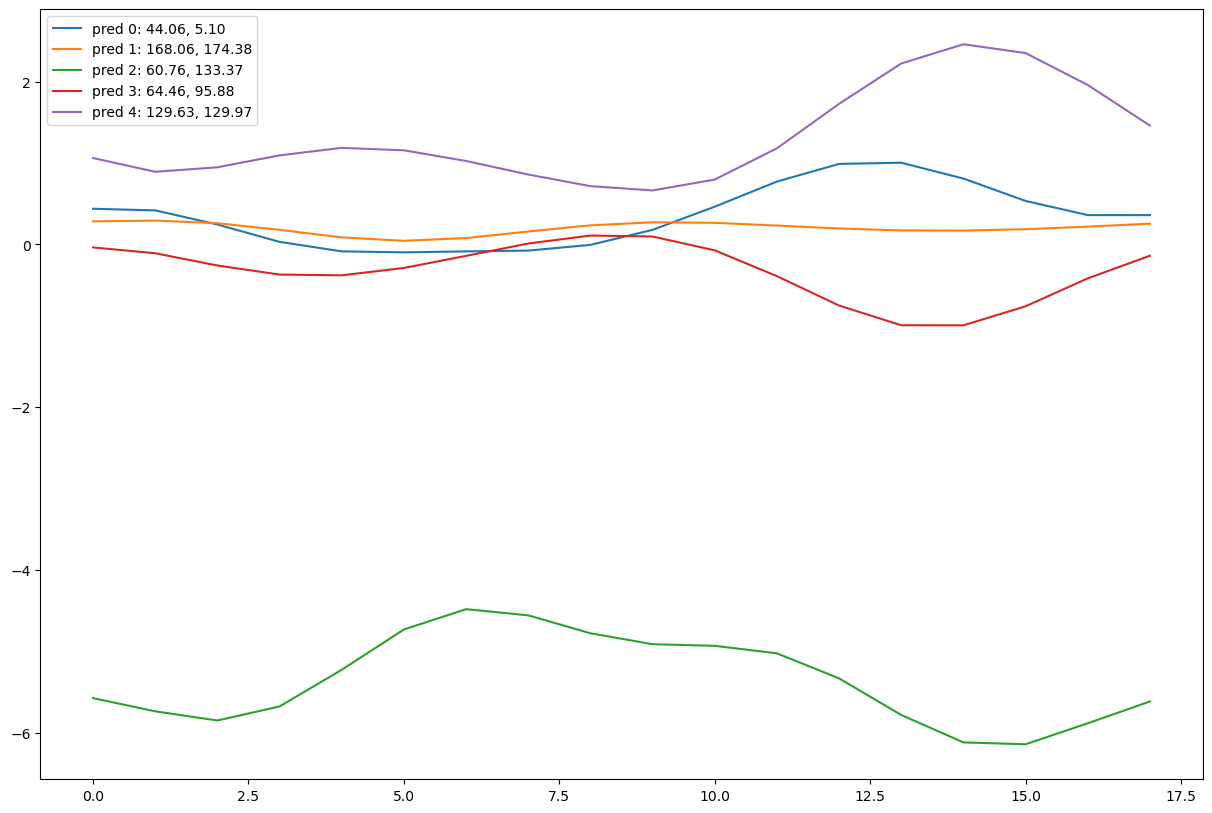

In [27]:
fig, ax = plt.subplots(1, figsize=(15, 10))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = full_delay_phase_results['preds'][i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

In [28]:
def channel_weights_to_pseudo_distrib(channel_weights, model, sharpness):
    thresh = 3
    channel_weights = np.clip(channel_weights, -thresh, thresh)
    # channel_weights = np.exp(channel_weights / thresh)
    channel_weights = channel_weights - np.min(
        channel_weights, axis=-1, keepdims=True) + 1e-4

    default_degs = np.arange(180)
    projection = model.raw_ys_to_channel_weights(
        default_degs, sharpness)
    pdistrib = channel_weights @ projection.T

    # now make them a distribution
    distrib = pdistrib / np.sum(pdistrib, axis=-1, keepdims=True)

    return distrib
    

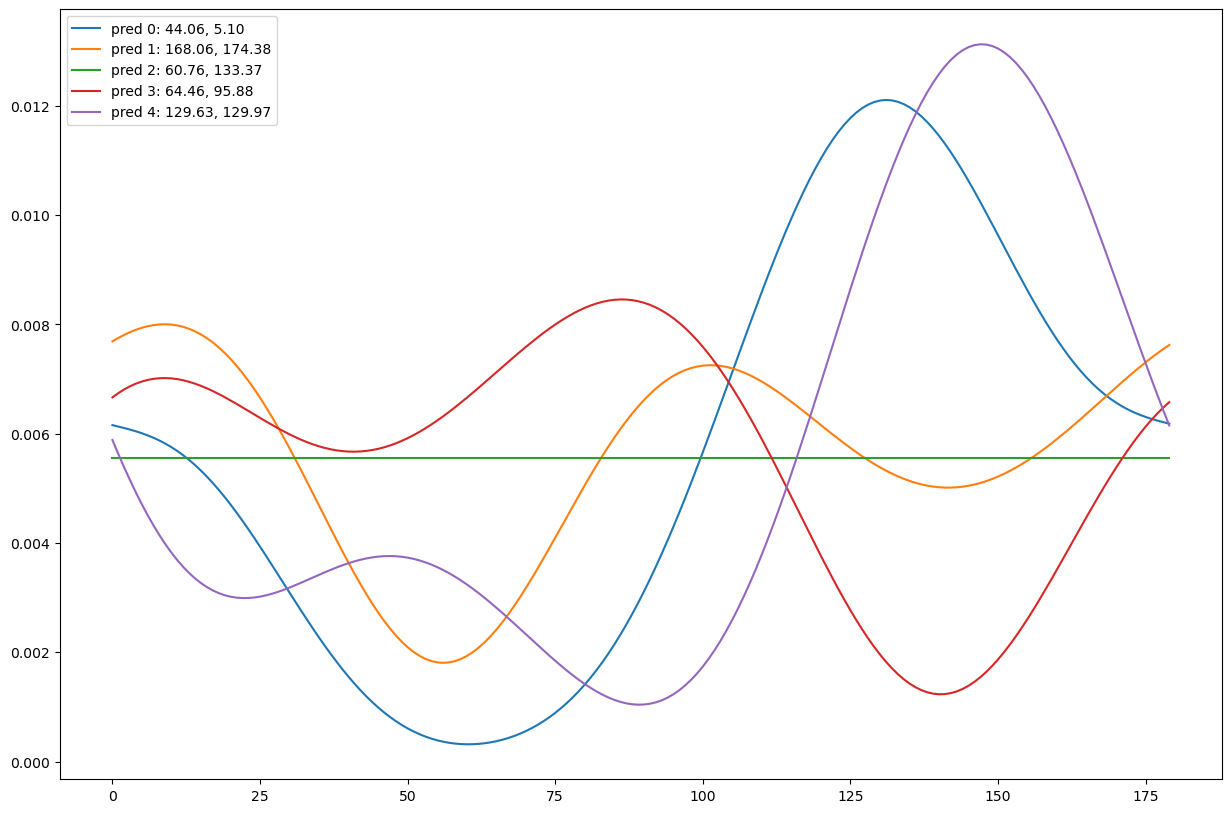

In [29]:
example_converted = channel_weights_to_pseudo_distrib(
    full_delay_phase_results['preds'], delay_model, 
    sharpness=20)
fig, ax = plt.subplots(1, figsize=(15, 10))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = example_converted[i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

#### flip and adjust the distribution --> so it aligns with the target we are checking

In [30]:
def shift_align_distrib(distrib, targets, refs=None):
    # filter out nan
    valid_mask = ~(np.isnan(targets))
    if refs is not None:
        valid_mask = valid_mask & ~(np.isnan(refs))
    distrib = distrib[valid_mask]
    targets = targets[valid_mask]
    if refs is not None:
        refs = refs[valid_mask]

    # determine the new x for each distrib
    default_degs = np.arange(180)
    default_diffs = deg_signed_diff(
        np.subtract.outer(targets, default_degs))
    relative_xs = - default_diffs
    if refs is not None:
        sd_diffs = deg_signed_diff(refs-targets)
        flip_mask = sd_diffs < 0
        relative_xs[flip_mask] = - relative_xs[flip_mask]
    relative_xs = (relative_xs % 180).astype(int)
    # shift it
    shifted = np.zeros_like(distrib)
    row_indices = np.arange(len(distrib))[:, np.newaxis]
    col_indices = np.arange(180)
    shifted[row_indices, relative_xs] = distrib[
        row_indices, col_indices]
    return shifted

In [31]:
y_distrib_preds = channel_weights_to_pseudo_distrib(
    full_delay_phase_results['preds'], delay_model, 
    sharpness=20)
y_distrib_pred_shifted_s1 = shift_align_distrib(
    y_distrib_preds, full_delay_phase_results['test_ys'][:, 0],
    refs=full_delay_phase_results['test_df']['prev_last_response'].values)
y_distrib_pred_shifted_s2 = shift_align_distrib(
    y_distrib_preds, full_delay_phase_results['test_ys'][:, 1],
    refs=full_delay_phase_results['test_df']['prev_last_response'].values)
y_distrib_pred_shifted_combined = np.mean(
    [y_distrib_pred_shifted_s1, y_distrib_pred_shifted_s2], axis=0)

In [32]:
def display_shifted_distrib(ax, distrib, label=None, min_max_y=1.2e-2):
    # filter out those too vague (likely large error)
    # print(f'kept: {np.mean(distrib.max(axis=-1) > min_max_y):.2f}')
    # distrib = distrib[distrib.max(axis=-1) > min_max_y]
    
    summed = np.mean(distrib, axis=0)
    summed_xs = deg_signed_diff(np.arange(180))
    summed_idx = np.argsort(summed_xs)
    summed = summed[summed_idx]
    summed_xs = summed_xs[summed_idx]
    ax.plot(summed_xs, summed, label=label)
    ax.axvline(0, color='red', linestyle='--')
    ax.set_xticks([-40, 40])
    ax.set_xticklabels([
        '<<away from previous resp<<', 
        '>>towards previous resp>>'], fontsize=14)
    ax.axhline(1/180, color='red', linestyle='--')
    ax.set_ylim([0.005, 0.0062])

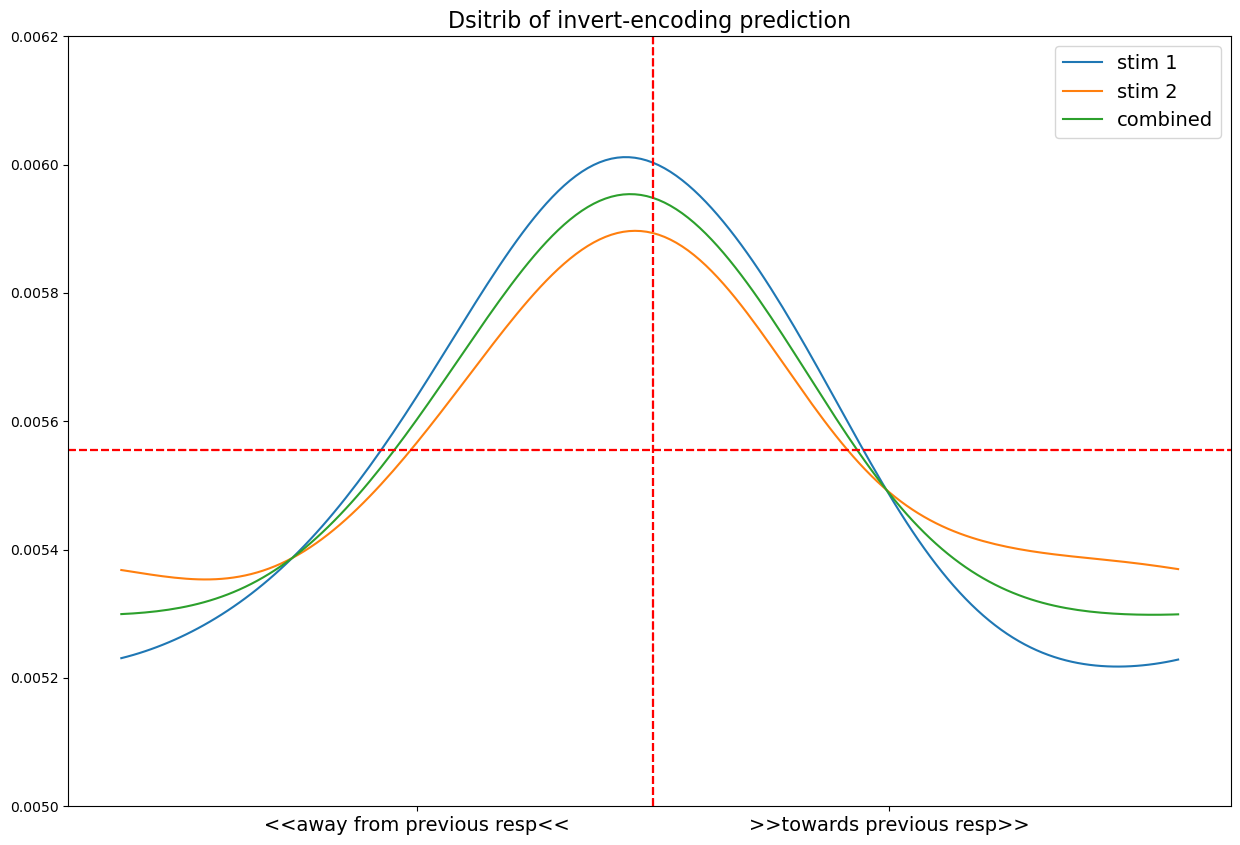

In [33]:
fig, ax = plt.subplots(1, figsize=(15, 10))
display_shifted_distrib(
    ax, y_distrib_pred_shifted_s1, label='stim 1')
display_shifted_distrib(
    ax, y_distrib_pred_shifted_s2, label='stim 2')
display_shifted_distrib(
    ax, y_distrib_pred_shifted_combined, 
    label='combined', min_max_y=1/100)
ax.set_title(
    'Dsitrib of invert-encoding prediction',
    fontsize=16)
ax.legend(fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded.png')
plt.savefig(plot_path)

#### group by serial difference

In [34]:
serial_diffs_s1 = np.abs(deg_signed_diff(
    full_delay_phase_results['test_df']['prev_last_response'].values -
    full_delay_phase_results['test_df']['stim_1'].values))
serial_diffs_s1 = serial_diffs_s1[~(np.isnan(serial_diffs_s1))]
serial_diffs_s2 = np.abs(deg_signed_diff(
    full_delay_phase_results['test_df']['prev_last_response'].values -
    full_delay_phase_results['test_df']['stim_2'].values)) 
serial_diffs_s2 = serial_diffs_s2[~(np.isnan(serial_diffs_s2))]

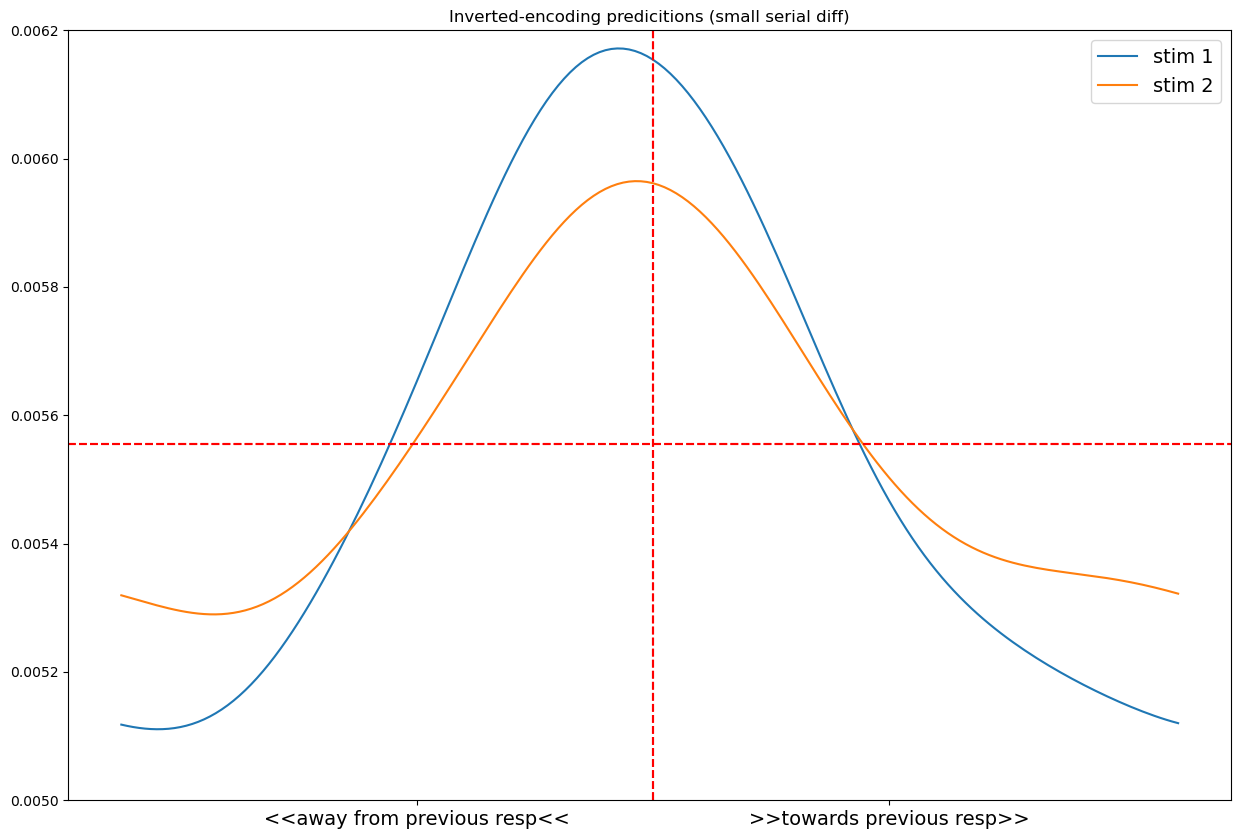

In [35]:
small_sd_stim1_mask = serial_diffs_s1 < 30
small_sd_stim2_mask = serial_diffs_s2 < 30
fig, ax = plt.subplots(1, figsize=(15, 10))
display_shifted_distrib(
    ax, y_distrib_pred_shifted_s1[small_sd_stim1_mask],
    label='stim 1') 
display_shifted_distrib(
    ax, y_distrib_pred_shifted_s2[small_sd_stim2_mask],
    label='stim 2')
ax.set_title('Inverted-encoding predicitions (small serial diff)')
ax.legend(fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_small_sd.png')
plt.savefig(plot_path)

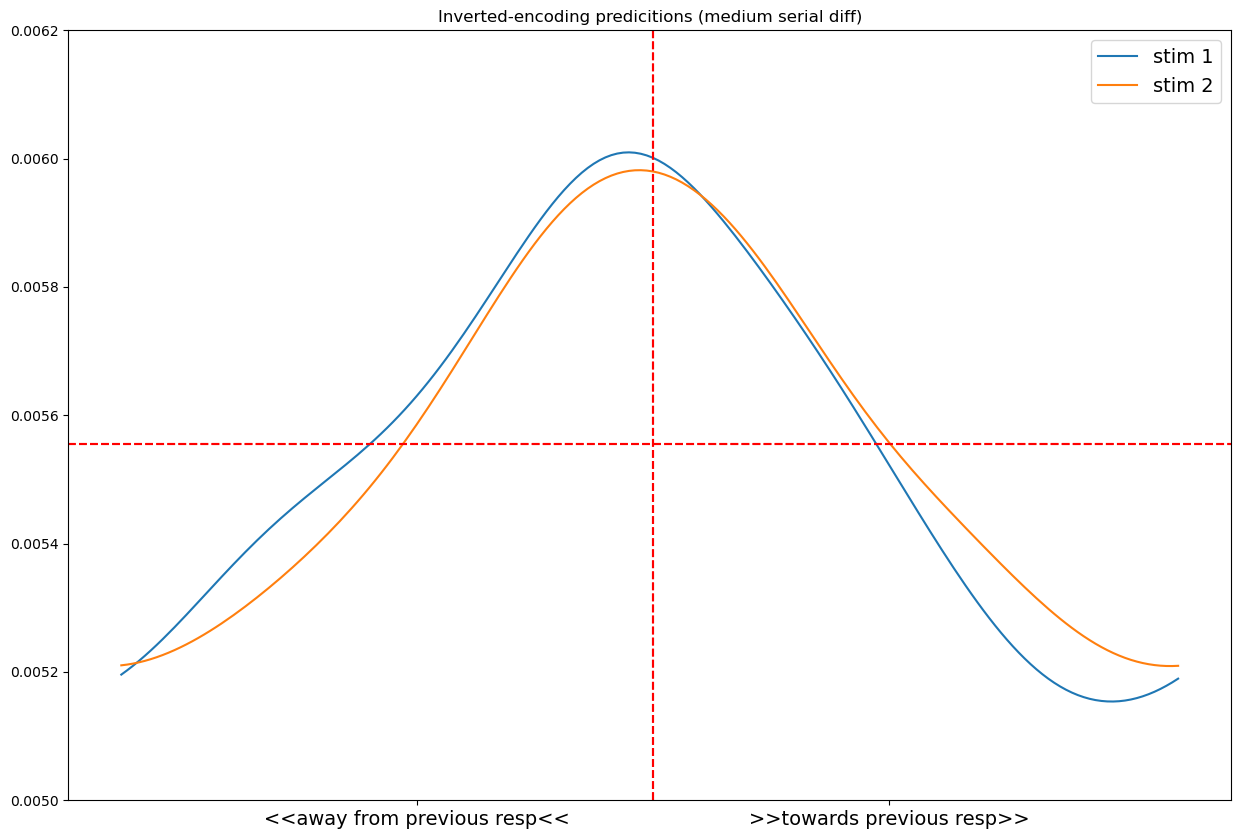

In [36]:
mid_sd_stim1_mask = (serial_diffs_s1 >= 30) & (serial_diffs_s1 < 60)
mid_sd_stim2_mask = (serial_diffs_s2 >= 30) & (serial_diffs_s2 < 60)
fig, ax = plt.subplots(1, figsize=(15, 10))
display_shifted_distrib(
    ax, y_distrib_pred_shifted_s1[mid_sd_stim1_mask],
    label='stim 1')
display_shifted_distrib(
    ax, y_distrib_pred_shifted_s2[mid_sd_stim2_mask],
    label='stim 2')
ax.set_title('Inverted-encoding predicitions (medium serial diff)')
ax.legend(fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_mid_sd.png')
plt.savefig(plot_path)

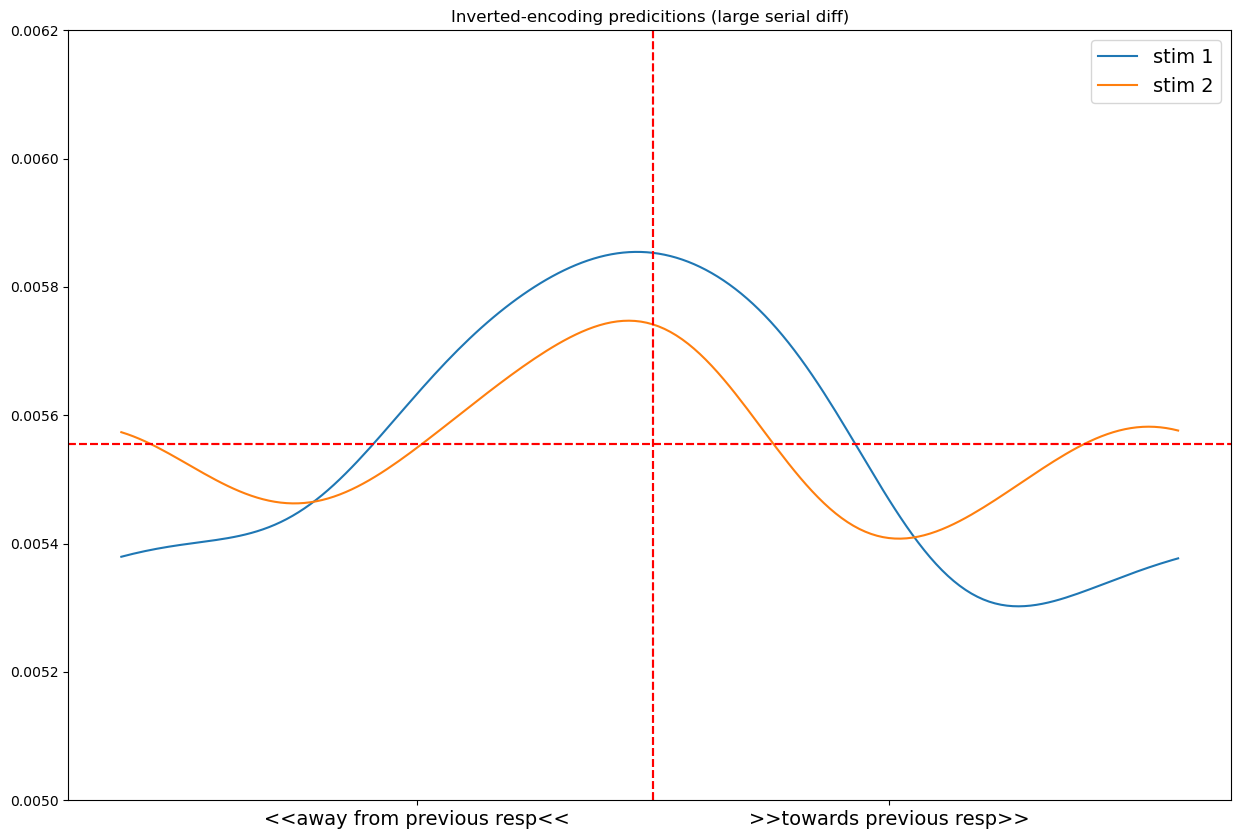

In [37]:
large_sd_stim1_mask = serial_diffs_s1 >= 60
large_sd_stim2_mask = serial_diffs_s2 >= 60
fig, ax = plt.subplots(1, figsize=(15, 10))
display_shifted_distrib(
    ax, y_distrib_pred_shifted_s1[large_sd_stim1_mask],
    label='stim 1')
display_shifted_distrib(
    ax, y_distrib_pred_shifted_s2[large_sd_stim2_mask],
    label='stim 2')
ax.set_title('Inverted-encoding predicitions (large serial diff)')
ax.legend(fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_large_sd.png')
plt.savefig(plot_path)

#### Compare different modes?

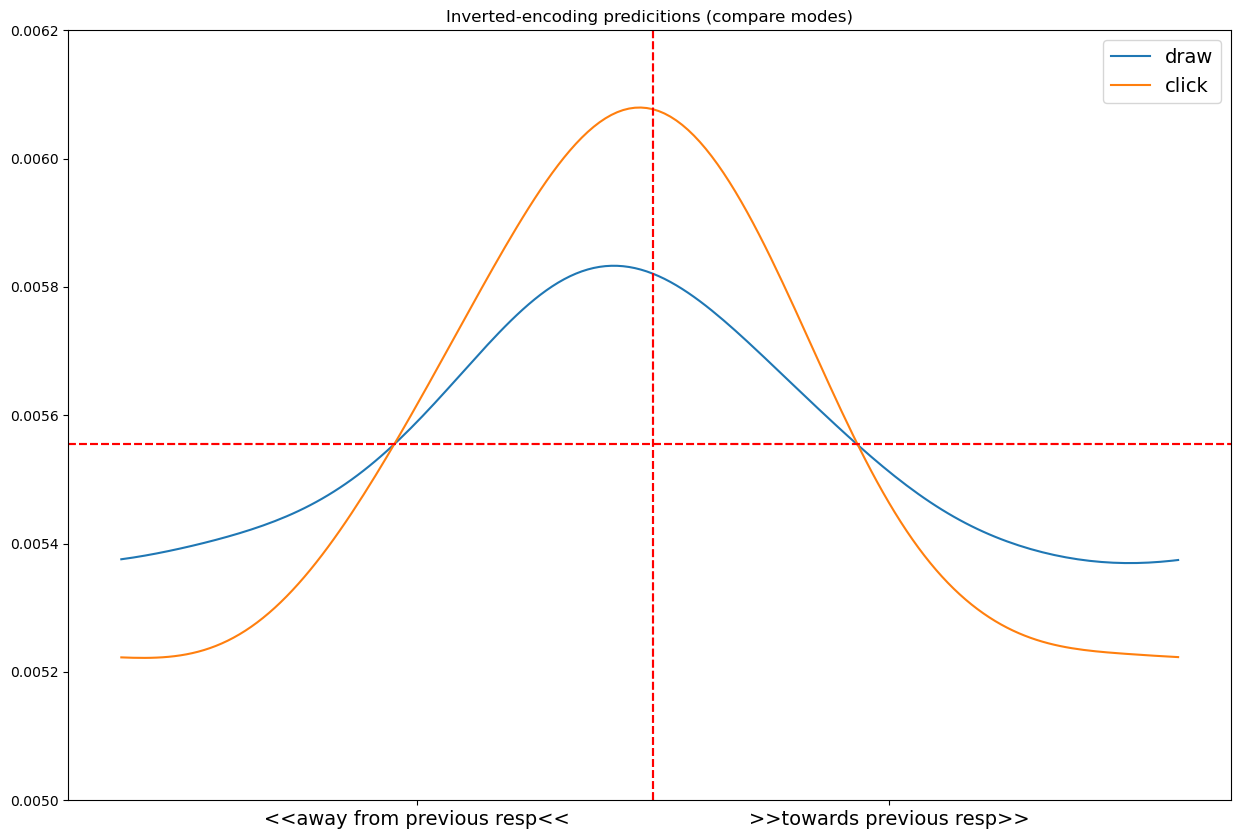

In [38]:
behav_df = full_delay_phase_results['test_df']
behav_df = behav_df[~(behav_df['prev_last_response'].isna())]
draw_mask = (behav_df['mode'] == 'draw').to_numpy()
click_mask = (behav_df['mode'] == 'click').to_numpy()
fig, ax = plt.subplots(1, figsize=(15, 10))
display_shifted_distrib(
    ax, y_distrib_pred_shifted_combined[draw_mask],
    label='draw', min_max_y=1/100)
display_shifted_distrib(
    ax, y_distrib_pred_shifted_combined[click_mask],
    label='click', min_max_y=1/100)
ax.set_title('Inverted-encoding predicitions (compare modes)')
ax.legend(fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes.png')
plt.savefig(plot_path)

### Train & test across modes

In [39]:
draw_delay_lmb = lambda df: (
    valid_both_lmb(df) & (df['mode'] == 'draw').to_numpy())
click_delay_lmb = lambda df: (
    valid_both_lmb(df) & (df['mode'] == 'click').to_numpy())
mode_lmbs = {
    'draw': draw_delay_lmb,
    'click': click_delay_lmb,
}


In [40]:
all_delay_across_modes = {}
item_weights_lmb = lambda df: np.ones((len(df), 2)) * 0.5
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        print(f'Trained on {train_mode}, tested on {test_mode}')
        n_subjects = len(all_subjs)
        train_lmb = mode_lmbs[train_mode]
        test_lmb = mode_lmbs[test_mode]
        modes_delay_phase_results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            delay_phase, delay_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            train_lmb, test_lmb, 
            item_weights_lmb, n_subjects)
        all_delay_across_modes[(train_mode, test_mode)] = modes_delay_phase_results

Trained on draw, tested on draw


Processing:   0%|          | 0/33 [00:00<?, ?it/s]

Processing: 100%|██████████| 33/33 [00:05<00:00,  6.01it/s]


Trained on draw, tested on click


Processing: 100%|██████████| 33/33 [00:06<00:00,  5.50it/s]


Trained on click, tested on draw


Processing: 100%|██████████| 33/33 [00:05<00:00,  5.87it/s]


Trained on click, tested on click


Processing: 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]


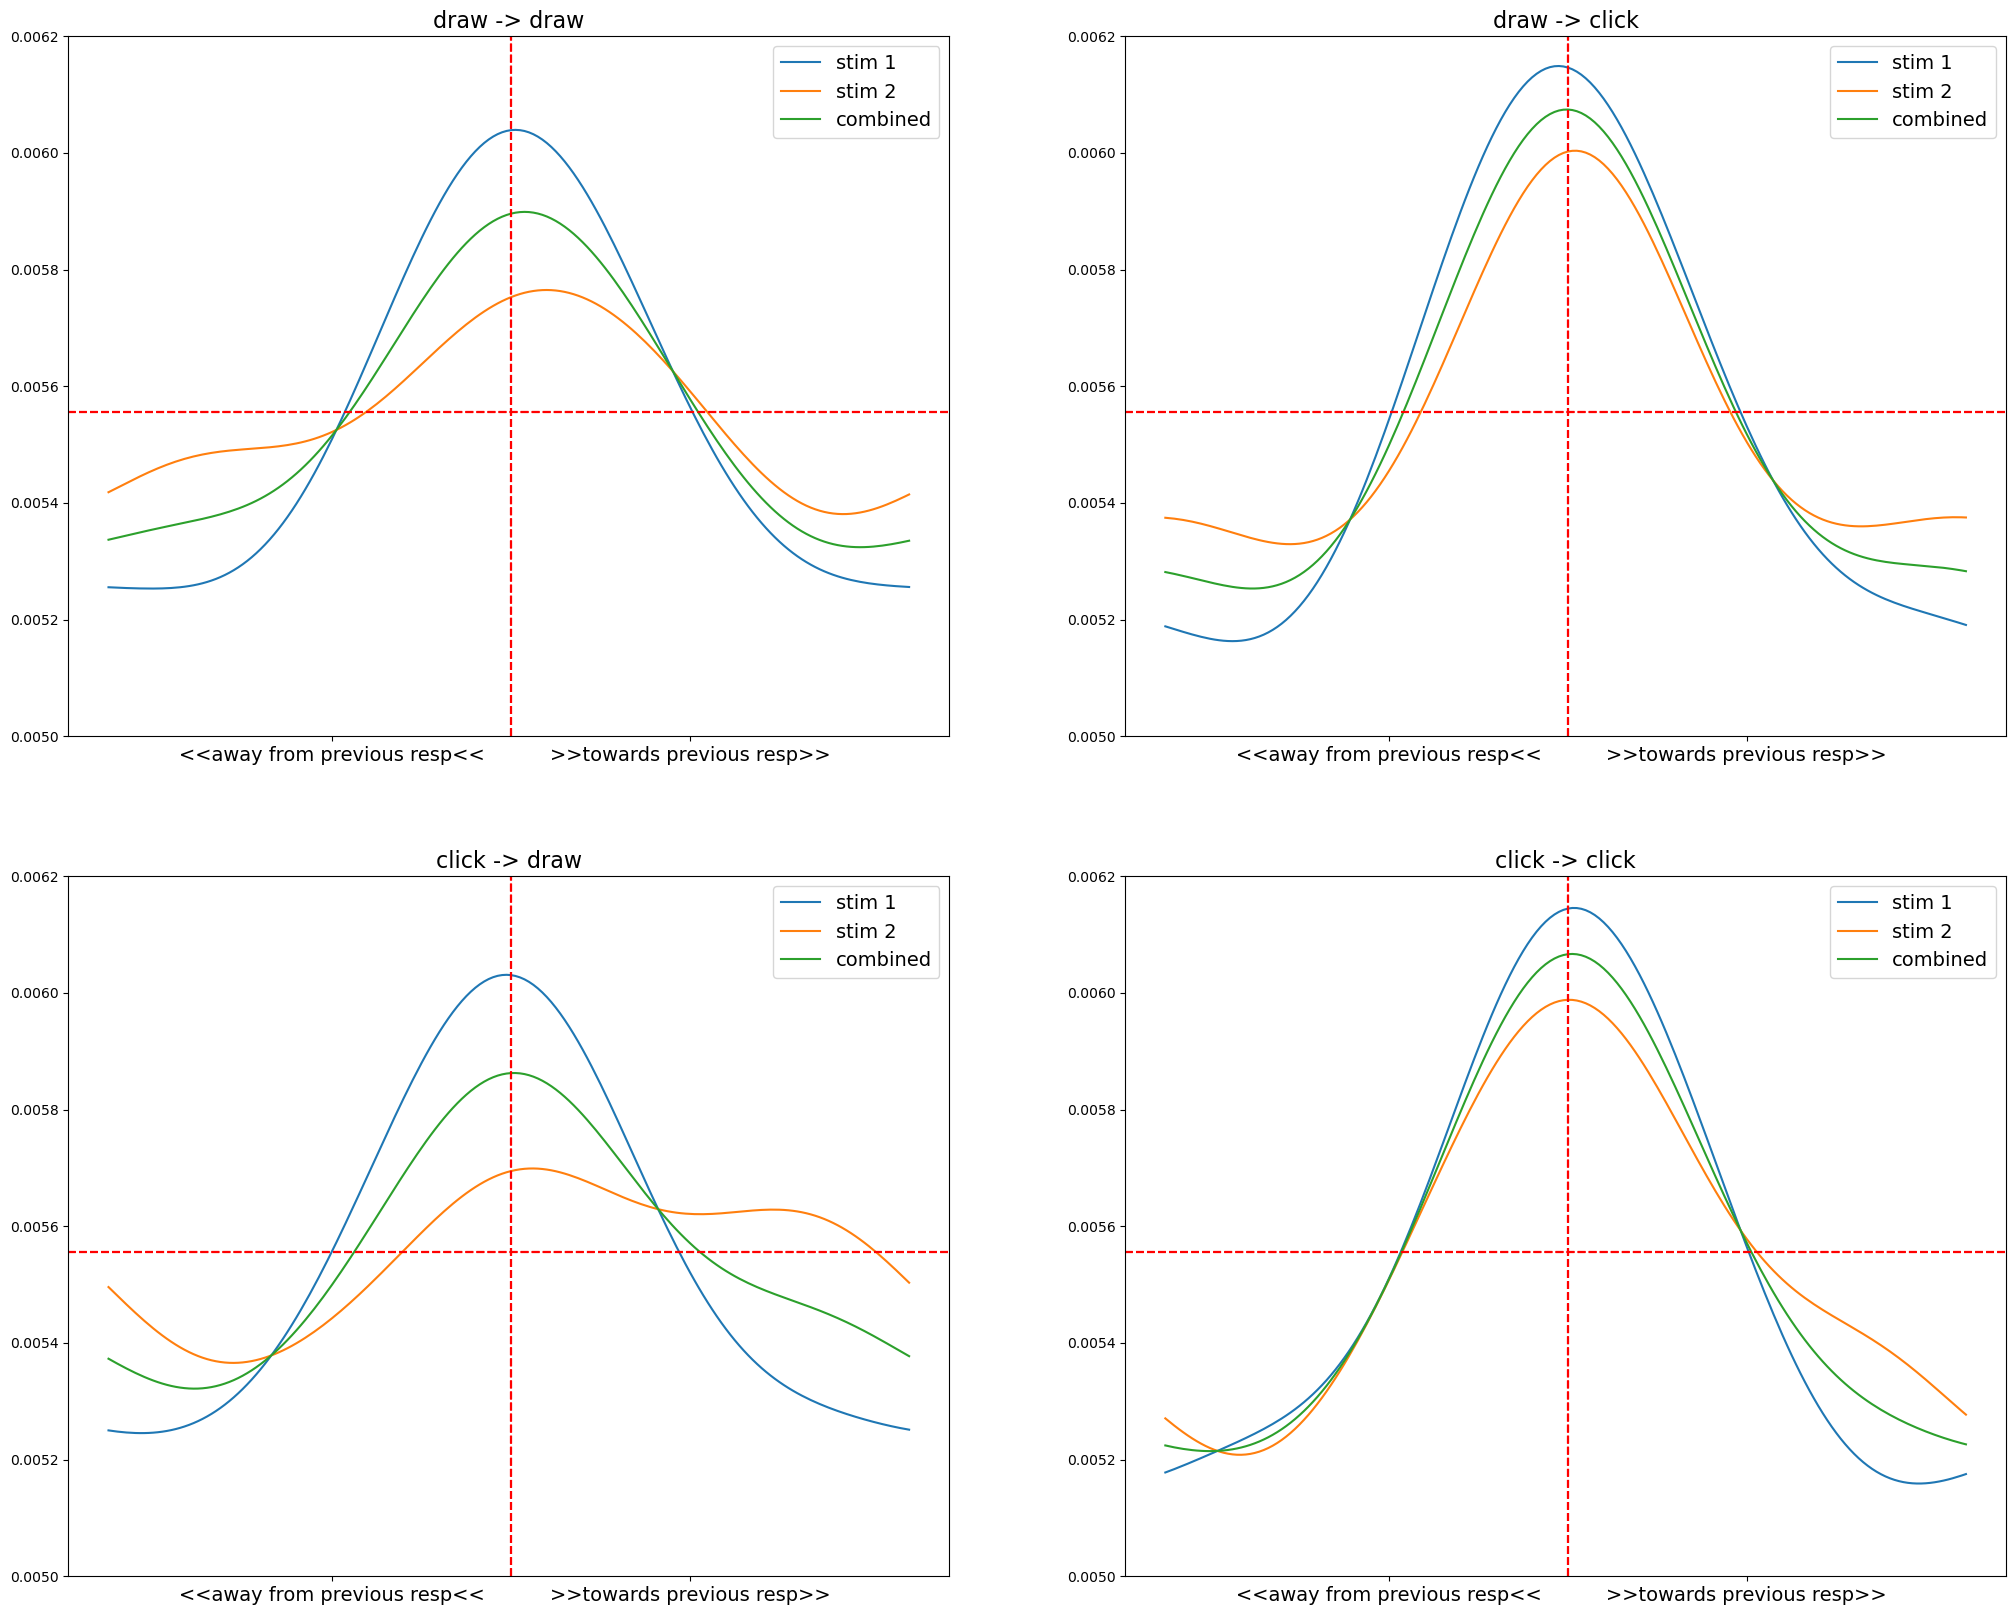

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(25, 20))
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        ax = axs[i, j]
        results = all_delay_across_modes[(train_mode, test_mode)]
        y_pred_distrib = channel_weights_to_pseudo_distrib(
            results['preds'], delay_model, sharpness=20)
        y_df = results['test_df']
        ys = results['test_ys']
        y1_distrib = shift_align_distrib(
            y_pred_distrib, ys[:, 0], refs=y_df['prev_last_response'].values)
        display_shifted_distrib(ax, y1_distrib, label='stim 1')
        y2_distrib = shift_align_distrib(
            y_pred_distrib, ys[:, 1], refs=y_df['prev_last_response'].values)
        display_shifted_distrib(ax, y2_distrib, label='stim 2')
        y_distrib_combined = np.mean([y1_distrib, y2_distrib], axis=0)
        display_shifted_distrib(ax, y_distrib_combined, label='combined', min_max_y=1/100)
        ax.set_title(
            f'{train_mode} -> {test_mode}', fontsize=16)
        ax.legend(fontsize=14)

plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_cross_modes.png')
plt.savefig(plot_path)

## Now further split the delay